# Finding Saddle-point Solutions with Chemical Potential Fields

This script demonstrates how to find the saddle-point solution of AB diblock copolymer systems with chemical potential fields (such as W_A, W_B, and W_C).

### 1. Setting simulation parameters and Initialization

\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
L_x &= 2.0 bN^{1/2} \\
L_y &= 2.0 bN^{1/2} \\
V &= L_x L_y \\ 
m_x &= 64 \\
m_y &= 64 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\chi N &= 20 \\
\end{align}

In numerical computation, $b^2N = 1$.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

# Simulation parameters
nx = [64,64]                       # grid number
lx = [2.0,2.0]                     # box size
stat_seg_lengths = {"A":1.0,       # statistical segment lengths
                    "B":1.0}        
ds = 0.01                          # contour step interval
chi_n = {"A,B":20}
monomer_types = ["A", "B"]  # monomer types

# Select platform ("cuda" or "cpu-mkl") for real-valued simulations
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

# Create an instance for computation box
cb = factory.create_computation_box(nx, lx) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

# Add AB diblock copolymers
volume_fraction = 1.0
blocks = [["A", 0.5, 0, 1],   # monomer type, statistical segment length, start index, end index
          ["B", 0.5, 1, 2]]
molecules.add_polymer(volume_fraction, blocks)

# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors
--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, A:
	 X, (X, O), (50, 50), (B50)A, 1, {0,1}

0, B:
	 X, (X, O), (50, 50), (A50)B, 1, {2,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
B:
	 0, X, 50, 0, {50}, 
A:
	 0, X, 50, 0, {50}, 
(B50)A:
	 1, X, 50, 1, {}, 
(A50)B:
	 1, X, 50, 1, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 200
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 0 %


### 2. Initial Potential Fields

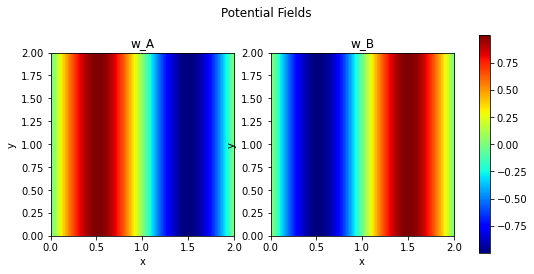

In [13]:
w_A =  np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for A
w_B = -np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for B
w = {"A": w_A, "B": w_B}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Potential Fields")
im = axes[0].imshow(w_A, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B, extent=(0, lx[0], 0, lx[1]), cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='x', ylabel='y')
axes[1].set(title='w_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 3. The Helmholtz Free Energy

* $CV=n$

* $\bar{\phi}_p=\frac{V_p}{V}$, $V=\frac{nN}{\rho_0}$, $V_p=\frac{n_pN_p}{\rho_0}$, ${\alpha_p}=\frac{N_p}{N}$

* The Helmholtz free energy $F$ is written as in 'per monomer' unit:
\begin{align}
\beta F &= -\sum_i n_i\log{Q_i} +
\rho_0\int d{\bf r}\left[\frac{1}{2} \sum_{ij} \chi_{ij}\phi_{i}({\bf r})\phi_{j}({\bf r})
-\sum_{i} w_{i}({\bf r})\phi_{i}({\bf r}) \right],  \ \ \ \ (\textrm{per monomer unit})
\end{align}

* The Helmholtz free energy  $F$ can be rewritten:
\begin{align}
Nw_{i} &\rightarrow w_{i}, \\
\frac{\beta F}{CV} &= \frac{\beta F}{n} = -\sum_i \frac{\bar{\phi}_i}{\alpha_i}\log{Q_i} +
\frac{1}{V}\int d{\bf r}\left[\frac{1}{2} \sum_{ij} \chi_{ij}N\phi_{i}({\bf r})\phi_{\beta}({\bf r})
-\sum_{i} w_{i}({\bf r})\phi_{i}({\bf r}) \right].  \ \ \ \ (\textrm{per chain unit})
\end{align}

* The Helmholtz free energy per $p$-chain:
\begin{align}
\frac{\beta F}{n_p} &= \frac{\alpha_p}{\bar{\phi}_p}\frac{\beta F}{CV}  \ \ \ \ (\textrm{per $p$-chain})
\end{align}

In [ ]:
def compute_concentrations(self, w):
    S = len(self.monomer_types)

    # For the given fields, compute the polymer statistics
    self.solver.compute_propagators(w)
    self.solver.compute_concentrations()

    # Compute total concentration for each monomer type
    phi = {}
    for monomer_type in self.monomer_types:
        phi[monomer_type] = self.solver.get_total_concentration(monomer_type)

    return phi

# The number of components
S = len(monomer_types)

# Polymer field theory for Multimonomer system
mpt = polymerfts.SymmetricPolymerTheory(monomer_types, chi_n, zeta_n=None)

# Iteration begins here
for scft_iter in range(1000):
    # Compute total concentration for each monomer type
    phi = compute_concentrations(w)

    # Convert monomer fields to auxiliary fields
    omega = mpt.to_aux_fields(w)

    # Calculate the total energy
    # energy_total = - self.cb.integral(self.phi_target*w_exchange[S-1])/self.cb.get_volume()
    total_partitions = [solver.get_total_partition(p) for p in range(molecules.get_n_polymer_types())]
    energy_total = mpt.compute_hamiltonian(molecules, omega, total_partitions, include_const_term=False)

    # Calculate difference between current total density and target density
    phi_total = np.zeros(cb.get_total_grid())
    for i in range(S):
        phi_total += phi[monomer_types[i]]
    # phi_diff = phi_total-self.phi_target
    phi_diff = phi_total-1.0

    # Calculate self-consistency error
    w_diff = np.zeros([S, cb.get_total_grid()], dtype=np.float64) # array for output fields
    for i in range(S):
        for j in range(S):
            w_diff[i,:] += matrix_chi[i,j]*phi[monomer_types[j]] - matrix_p[i,j]*w[j,:]
        # w_diff[i,:] -= self.phi_target_pressure

    # Keep the level of functional derivatives
    for i in range(S):
        w_diff[i] -= cb.integral(w_diff[i])/cb.get_volume()

    # error_level measures the "relative distance" between the input and output fields
    old_error_level = error_level
    error_level = 0.0
    error_normal = 1.0  # add 1.0 to prevent divergence
    for i in range(S):
        error_level += cb.inner_product(w_diff[i],w_diff[i])
        error_normal += cb.inner_product(w[i],w[i])
    error_level = np.sqrt(error_level/error_normal)

    # Print iteration # and error levels and check the mass conservation
    mass_error = cb.integral(phi_diff)/cb.get_volume()
    
    print("%8d %12.3E " % (scft_iter, mass_error), end=" [ ")
    for p in range(molecules.get_n_polymer_types()):
        print("%13.7E " % (solver.get_total_partition(p)), end=" ")
    print("] %15.9f %15.7E " % (energy_total, error_level))

One of eigenvalues is zero for given chiN values.
------------ Polymer Field Theory for Multimonomer ------------
Eigenvalues:
	 [-20.   0.]
Eigenvectors [v1, v2, ...] :
	 [[ 1.  1.]
	 [-1.  1.]]
Mapping matrix A:
	 [[ 1.  1.]
	 [-1.  1.]]
Real Fields:  [0]
Imaginary Fields:  [1]
In Hamiltonian:
	reference energy:  5.0
	coefficients of int of mu(r)/V:  [-0. -1.]
	coefficients of int of mu(r)^2/V:  [0.05 0.  ]
	dH_ref/dχN:  {'A,B': 0.24999999999053554}
	d(coef of mu(r))/dχN:  {'A,B': array([0., 0.])}
	d(coef of mu(r)^2)/dχN:  {'A,B': array([-0.0025,  0.    ])}


TypeError: compute_concentrations() missing 1 required positional argument: 'w'

['A', 'B']